<a href="https://colab.research.google.com/github/B10956048/113_Finance/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

In [18]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 下載股票資料 (2454.TW)
data = yf.download('2454.TW', start='2020-01-01', end='2023-01-01')
closing_prices = data['Close'].values.reshape(-1, 1)
dates = data.index  # 獲取日期信息

#closing_prices

[*********************100%***********************]  1 of 1 completed


In [19]:
# 標準化資料
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

In [20]:
# 建立訓練集和測試集（使用 20 天的收盤價來預測第 21 天的收盤價）
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_prices, seq_length)

# 將資料轉換為 Tensor 格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
 #定義 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        _, (hn, _) = self.lstm(x, (h_0, c_0))
        out = self.linear(hn[-1])
        return out

# 初始化模型、損失函數和優化器
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 LSTM 模型
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# 預測結果
model.eval()
train_predictions, test_predictions = [], []

# 生成訓練集預測
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        train_predictions.append(model(X_batch))
train_predictions = torch.cat(train_predictions).cpu().numpy()
train_predictions = scaler.inverse_transform(train_predictions)

# 生成測試集預測
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_predictions.append(model(X_batch))
test_predictions = torch.cat(test_predictions).cpu().numpy()
test_predictions = scaler.inverse_transform(test_predictions)

# 反標準化實際數據
train_y_actual = scaler.inverse_transform(train_y.cpu().numpy())
test_y_actual = scaler.inverse_transform(test_y.cpu().numpy())

Epoch 1/100, Loss: 0.2820
Epoch 2/100, Loss: 0.0602
Epoch 3/100, Loss: 0.0359
Epoch 4/100, Loss: 0.0252
Epoch 5/100, Loss: 0.0140
Epoch 6/100, Loss: 0.0052
Epoch 7/100, Loss: 0.0045
Epoch 8/100, Loss: 0.0036
Epoch 9/100, Loss: 0.0034
Epoch 10/100, Loss: 0.0029
Epoch 11/100, Loss: 0.0028
Epoch 12/100, Loss: 0.0024
Epoch 13/100, Loss: 0.0022
Epoch 14/100, Loss: 0.0020
Epoch 15/100, Loss: 0.0021
Epoch 16/100, Loss: 0.0019
Epoch 17/100, Loss: 0.0018
Epoch 18/100, Loss: 0.0019
Epoch 19/100, Loss: 0.0017
Epoch 20/100, Loss: 0.0017
Epoch 21/100, Loss: 0.0017
Epoch 22/100, Loss: 0.0017
Epoch 23/100, Loss: 0.0016
Epoch 24/100, Loss: 0.0016
Epoch 25/100, Loss: 0.0016
Epoch 26/100, Loss: 0.0016
Epoch 27/100, Loss: 0.0016
Epoch 28/100, Loss: 0.0015
Epoch 29/100, Loss: 0.0016
Epoch 30/100, Loss: 0.0017
Epoch 31/100, Loss: 0.0016
Epoch 32/100, Loss: 0.0015
Epoch 33/100, Loss: 0.0016
Epoch 34/100, Loss: 0.0014
Epoch 35/100, Loss: 0.0014
Epoch 36/100, Loss: 0.0014
Epoch 37/100, Loss: 0.0014
Epoch 38/1

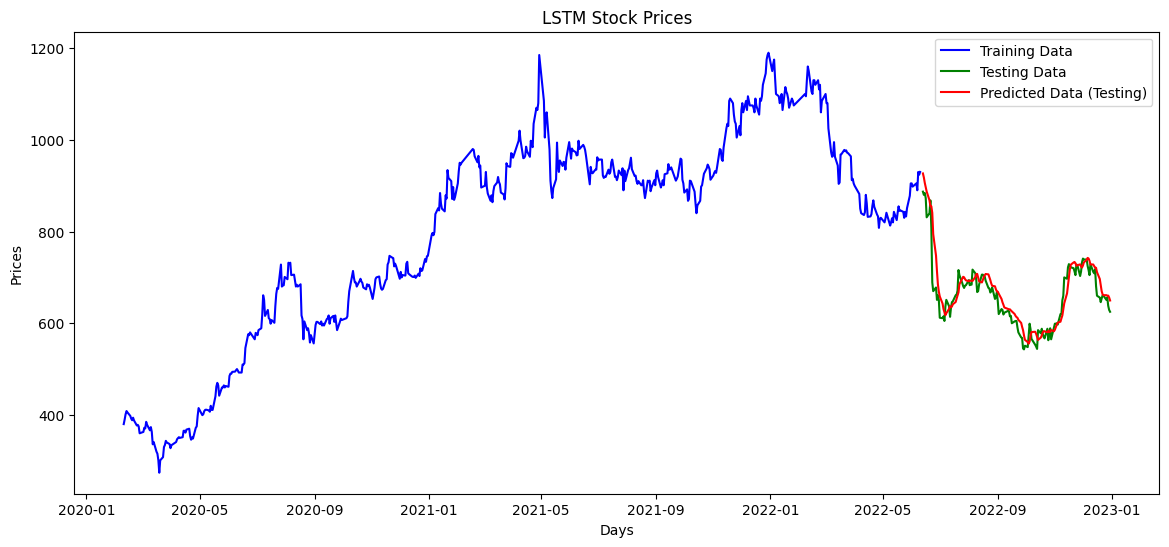

In [22]:
# 視覺化結果
import matplotlib.pyplot as plt

# 獲取日期區間，用於對應訓練集和測試集的可視化
train_dates = dates[seq_length:train_size + seq_length]
test_dates = dates[train_size + seq_length:]

# 繪圖
plt.figure(figsize=(14, 6))

# 繪製訓練集真實數據
plt.plot(train_dates, train_y_actual, label='Training Data', color='blue')

# 繪製測試集真實數據
plt.plot(test_dates, test_y_actual, label='Testing Data', color='green')

# 繪製訓練集預測數據
#plt.plot(train_dates, train_predictions, label='Predicted Data (Training)', color='red', linestyle='--')

# 繪製測試集預測數據
plt.plot(test_dates, test_predictions, label='Predicted Data (Testing)', color='red')
# 標題和標籤
plt.title('LSTM Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

### 作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

In [23]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 下載股票資料 (2330.TW)
data = yf.download('2454.TW', start='2020-01-01', end='2023-01-01')
closing_prices = data['Close'].values.reshape(-1, 1)
dates = data.index  # 獲取日期信息

# 標準化資料
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed


In [24]:
# 建立訓練集和測試集（使用 20 天的收盤價來預測第 21 天的收盤價）
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_prices, seq_length)

# 將資料轉換為 Tensor 格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
# 定義位置編碼（Positional Encoding）
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# 定義改進版 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, output_size=1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead), num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # 加入位置編碼
        x = self.embedding(x)
        x = self.pos_encoder(x.permute(1, 0, 2) * np.sqrt(self.d_model))
        x = self.transformer(x)
        x = x.mean(dim=0)  # 將時間維度上取平均，得到 (batch_size, d_model)
        out = self.fc(x)
        return out

# 初始化模型、損失函數和優化器
model = TransformerModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 Transformer 模型
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# 預測結果
model.eval()
train_predictions, test_predictions = [], []

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 0.5134
Epoch 2/100, Loss: 0.0848
Epoch 3/100, Loss: 0.0597
Epoch 4/100, Loss: 0.0479
Epoch 5/100, Loss: 0.0456
Epoch 6/100, Loss: 0.0411
Epoch 7/100, Loss: 0.0392
Epoch 8/100, Loss: 0.0338
Epoch 9/100, Loss: 0.0245
Epoch 10/100, Loss: 0.0185
Epoch 11/100, Loss: 0.0159
Epoch 12/100, Loss: 0.0173
Epoch 13/100, Loss: 0.0141
Epoch 14/100, Loss: 0.0133
Epoch 15/100, Loss: 0.0139
Epoch 16/100, Loss: 0.0161
Epoch 17/100, Loss: 0.0137
Epoch 18/100, Loss: 0.0142
Epoch 19/100, Loss: 0.0137
Epoch 20/100, Loss: 0.0116
Epoch 21/100, Loss: 0.0120
Epoch 22/100, Loss: 0.0148
Epoch 23/100, Loss: 0.0176
Epoch 24/100, Loss: 0.0149
Epoch 25/100, Loss: 0.0155
Epoch 26/100, Loss: 0.0116
Epoch 27/100, Loss: 0.0115
Epoch 28/100, Loss: 0.0131
Epoch 29/100, Loss: 0.0128
Epoch 30/100, Loss: 0.0216
Epoch 31/100, Loss: 0.0212
Epoch 32/100, Loss: 0.0134
Epoch 33/100, Loss: 0.0131
Epoch 34/100, Loss: 0.0123
Epoch 35/100, Loss: 0.0130
Epoch 36/100, Loss: 0.0123
Epoch 37/100, Loss: 0.0120
Epoch 38/1

In [26]:
# 生成訓練集預測
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        train_predictions.append(model(X_batch))
train_predictions = torch.cat(train_predictions).cpu().numpy()
train_predictions = scaler.inverse_transform(train_predictions)

# 生成測試集預測
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_predictions.append(model(X_batch))
test_predictions = torch.cat(test_predictions).cpu().numpy()
test_predictions = scaler.inverse_transform(test_predictions)

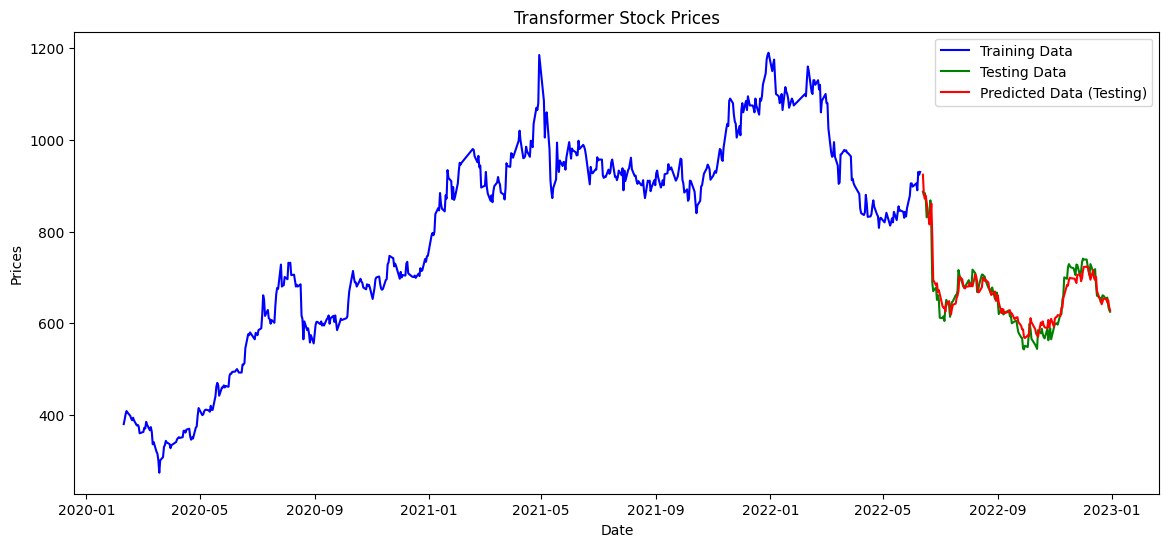

In [28]:
# 反標準化實際數據
train_y_actual = scaler.inverse_transform(train_y.cpu().numpy())
test_y_actual = scaler.inverse_transform(test_y.cpu().numpy())

# 獲取日期區間，用於對應訓練集和測試集的可視化
train_dates = dates[seq_length:train_size + seq_length]
test_dates = dates[train_size + seq_length:]

# 繪圖
plt.figure(figsize=(14, 6))

# 繪製訓練集真實數據
plt.plot(train_dates, train_y_actual, label='Training Data', color='blue')

# 繪製測試集真實數據
plt.plot(test_dates, test_y_actual, label='Testing Data', color='green')

# 繪製訓練集預測數據
#plt.plot(train_dates, train_predictions, label='Predicted Data (Training)', color='red', linestyle='--')

# 繪製測試集預測數據
plt.plot(test_dates, test_predictions, label='Predicted Data (Testing)', color='red')

# 標題和標籤
plt.title('Transformer Stock Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()